# Proyecto I - Aprendizaje Máquina

## Integrantes:
- **Cristobal Hachim**
- **Ignacio Duarte**
- **Cristopher Arredondo**
- **Alvaro Brizuela**
- **Felipe Moscoso**

## Introducción
Los Sistemas de Grupos Relacionados por el Diagnóstico (GRD) constituyen un método estandarizado para agrupar estancias hospitalarias en categorías clínicas homogéneas, cuyo objetivo es reflejar la complejidad del paciente y el consumo de recursos asociados. Tradicionalmente, la asignación de un GRD se realiza al alta mediante reglas fijas basadas en el diagnóstico principal, las comorbilidades, los procedimientos realizados, la edad y el sexo, lo que limita su capacidad de adaptación a nuevas prácticas clínicas o combinaciones atípicas de diagnósticos. Predecir de forma temprana el GRD —incluso al ingreso o durante las primeras horas de hospitalización— permitiría a los hospitales anticipar necesidades de camas, personal y suministros, optimizar la planificación presupuestaria y detectar posibles errores de codificación antes de la facturación. Sin embargo, esta tarea plantea un desafío de clasificación multiclase de alta dimensionalidad, dado el enorme número de códigos ICD‑9/ICD‑10 y procedimientos, así como las complejas interacciones entre comorbilidades y tratamientos.

---

**Posible Cambio**

---
Por ello, en este proyecto exploraremos desde técnicas clásicas (regresión logística, árboles de decisión) hasta métodos avanzados de aprendizaje automático (Random Forest, XGBoost, redes neuronales recurrentes y basadas en atención), con el fin de diseñar un sistema preciso, escalable y lo suficientemente interpretable para apoyar la toma de decisiones clínicas y administrativas.

---

## Limpieza del CSV

In [34]:
import pandas as pd

In [35]:
corpus=[]
target=[]
edad=[]
sexo=[]
severidad=[]
archivo=open("data/dataset_elpino.csv",encoding="utf-8")
header=archivo.readline().strip().split(";")
features=[]
for col in header:
    col=col.split("-")[0].strip()
    if col.startswith("Diag") or col.startswith("Proc"):
        col=col.split(" ")
        col=col[0]+col[1]
    features.append(col)
for linea in archivo:
    row=[]
    linea=linea.strip().split(";")
    for i in range(len(linea)):
        col=linea[i].split("-")[0].strip()
        if i==67:
            grd=col
            target.append(grd)
        elif i==66:
            sexo.append(1 if col=="Mujer" else 0)
        elif i==65:
            edad.append(int(col))
        else:
            row.append(col)
    corpus.append(row)

In [36]:
df=pd.DataFrame(corpus,columns=features[:-3])
df["GRD"]=target

In [37]:
df.to_csv("output/dataset-el-pino-clean.csv",index=False,encoding="utf-8")

## Analisis exploratorio de datos(EDA)

### Limpieza de Datos

Cargamos el dataset una vez limpio el CSV

In [38]:
df_clean = pd.read_csv("output/dataset-el-pino-clean.csv")

Obtendremos la información de los datos, para ver si hay algún dato nulo o algún dato que no esté en el formato correcto.

In [39]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14561 entries, 0 to 14560
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Diag01    14561 non-null  object 
 1   Diag02    13352 non-null  object 
 2   Diag03    11874 non-null  object 
 3   Diag04    10434 non-null  object 
 4   Diag05    9190 non-null   object 
 5   Diag06    8167 non-null   object 
 6   Diag07    7153 non-null   object 
 7   Diag08    5977 non-null   object 
 8   Diag09    4842 non-null   object 
 9   Diag10    3865 non-null   object 
 10  Diag11    2987 non-null   object 
 11  Diag12    2323 non-null   object 
 12  Diag13    1800 non-null   object 
 13  Diag14    1431 non-null   object 
 14  Diag15    1138 non-null   object 
 15  Diag16    923 non-null    object 
 16  Diag17    759 non-null    object 
 17  Diag18    623 non-null    object 
 18  Diag19    515 non-null    object 
 19  Diag20    429 non-null    object 
 20  Diag21    353 non-null    ob

In [40]:
df_clean.isna().sum()

Diag01          0
Diag02       1209
Diag03       2687
Diag04       4127
Diag05       5371
            ...  
Proced27    13138
Proced28    13261
Proced29    13379
Proced30    13498
GRD             0
Length: 66, dtype: int64

Como podemos observar el dataset contiene 14561 filas y 67 columnas, además de que existen muchos datos nulos, por lo que debemos limpiarlo.

### Distribución de las clases

In [41]:
df_clean['GRD'].value_counts()

GRD
146101    813
146121    639
146131    538
158171    389
134161    325
         ... 
214103      1
54223       1
114142      1
131122      1
134153      1
Name: count, Length: 526, dtype: int64

Tenemos 526 clases, lo que hace que el problema sea un problema de clasificación multiclase

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

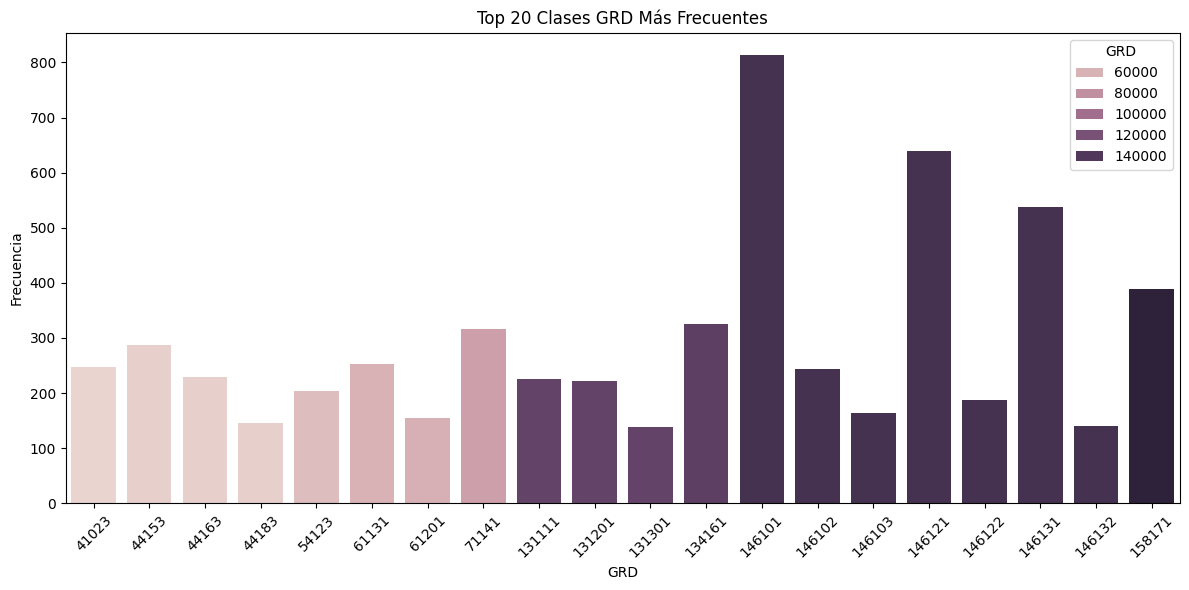

In [43]:
top_n = 20
top_grds = df_clean['GRD'].value_counts().nlargest(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_grds.index, y=top_grds.values, hue=top_grds.index, dodge=False)
plt.title(f"Top {top_n} Clases GRD Más Frecuentes")
plt.xlabel("GRD")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

A continuación, se muestra la distribución de las 20 clases más frecuentes, donde podemos observar que las clases 146101, 146121, 146131 son las más frecuentes, esto nos confirma que existe un fuerte desbalanceo en los datos, por lo que debemos tener cuidado al momento de entrenar el modelo, ya que puede que el modelo se sobreentrene en las clases más frecuentes y no generalice bien a las clases menos frecuentes.

Vamos a extraer las columnas de diagnóstico y procedimiento, para realizar el analisis de las columnas.

In [44]:
diagnosticos_cols = [col for col in df_clean.columns if "Diag" in col]
procedimientos_cols = [col for col in df_clean.columns if "Proced" in col]
print("Diagnósticos:", diagnosticos_cols)
print("Procedimientos:", procedimientos_cols)


Diagnósticos: ['Diag01', 'Diag02', 'Diag03', 'Diag04', 'Diag05', 'Diag06', 'Diag07', 'Diag08', 'Diag09', 'Diag10', 'Diag11', 'Diag12', 'Diag13', 'Diag14', 'Diag15', 'Diag16', 'Diag17', 'Diag18', 'Diag19', 'Diag20', 'Diag21', 'Diag22', 'Diag23', 'Diag24', 'Diag25', 'Diag26', 'Diag27', 'Diag28', 'Diag29', 'Diag30', 'Diag31', 'Diag32', 'Diag33', 'Diag34', 'Diag35']
Procedimientos: ['Proced01', 'Proced02', 'Proced03', 'Proced04', 'Proced05', 'Proced06', 'Proced07', 'Proced08', 'Proced09', 'Proced10', 'Proced11', 'Proced12', 'Proced13', 'Proced14', 'Proced15', 'Proced16', 'Proced17', 'Proced18', 'Proced19', 'Proced20', 'Proced21', 'Proced22', 'Proced23', 'Proced24', 'Proced25', 'Proced26', 'Proced27', 'Proced28', 'Proced29', 'Proced30']


In [45]:
df_nulls = df_clean[diagnosticos_cols + procedimientos_cols].isna().sum()
df_clean[diagnosticos_cols + procedimientos_cols].isna().sum()

Diag01          0
Diag02       1209
Diag03       2687
Diag04       4127
Diag05       5371
            ...  
Proced26    12989
Proced27    13138
Proced28    13261
Proced29    13379
Proced30    13498
Length: 65, dtype: int64

Segun el analisis que hicimos sobre `df_nulls` concluimos que todas las columnas excepto `Diag01` y `Proc01` tienen datos nulos, los valores nulos aumentan progresivamente a medida que avanzamos en las columnas, por lo que decidimos rellenar los valores nulos con `SIN_CODIGO` para preservar esta ausencia de datos, ya que es importante para el modelo, ya que si no lo hacemos el modelo no podrá aprender de estos datos y no podrá generalizar bien a los datos de prueba.

Se concluye que los 

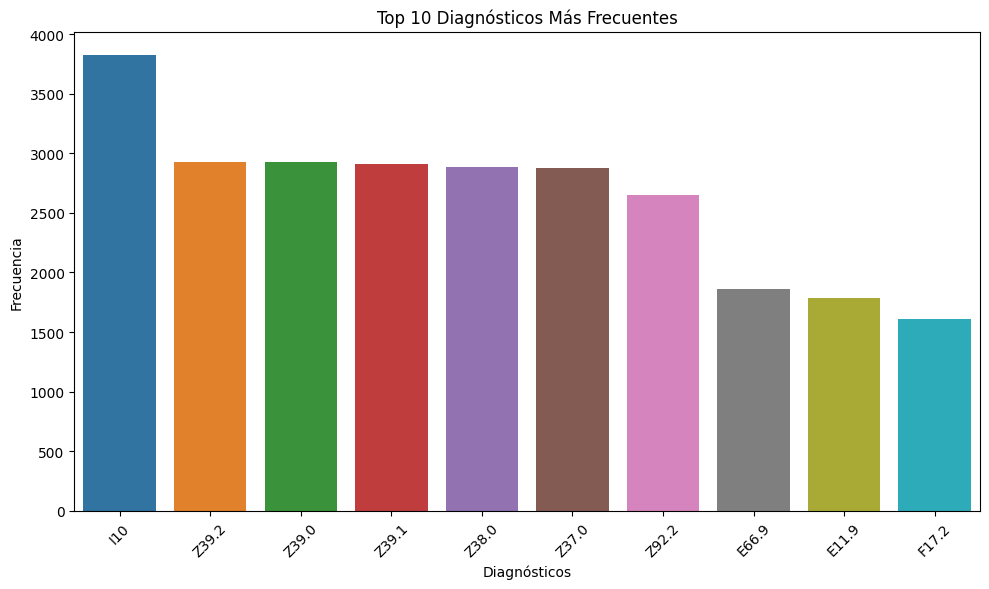

In [46]:
from collections import Counter

all_diags = df_clean[diagnosticos_cols].values.ravel()
diag_counts = Counter(all_diags[~pd.isna(all_diags)])

top_10_diags = diag_counts.most_common(10)
labels, values = zip(*top_10_diags)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(labels), y=list(values), hue=labels, dodge=False)
plt.title("Top 10 Diagnósticos Más Frecuentes")
plt.xlabel("Diagnósticos")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Como se observa, hay una alta concentracion en diagnosticos comunes ya que sumando los 10 mas frecuentes cubren aproximadamente 50% - 60% de los datos, por lo que es importante tener en cuenta esto al momento de entrenar el modelo, ya que puede que el modelo se sobreentrene en los diagnósticos más frecuentes y no generalice bien a los diagnósticos menos frecuentes.

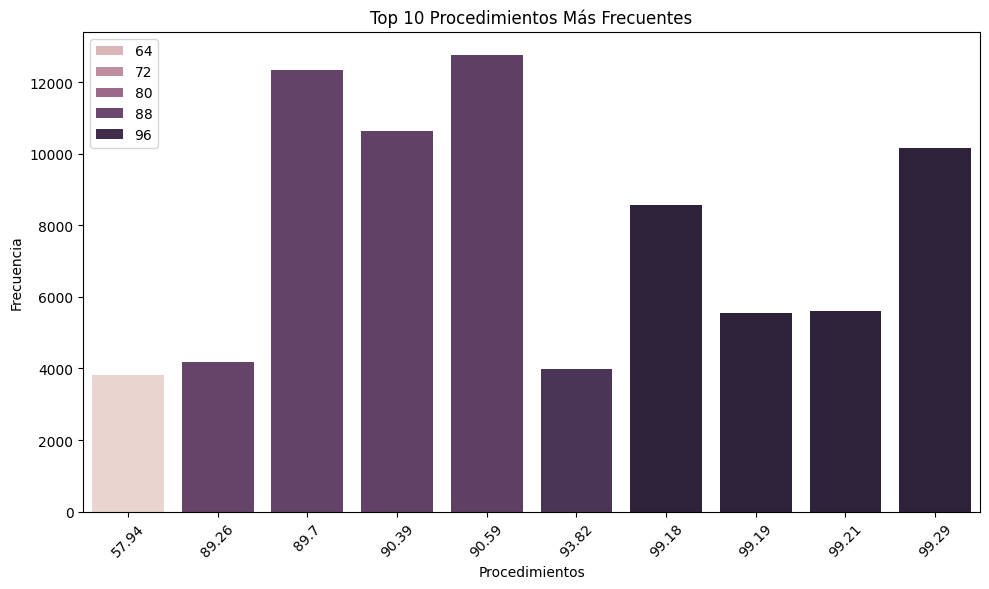

In [47]:
all_procs = df_clean[procedimientos_cols].values.ravel()
proc_counts = Counter(all_procs[~pd.isna(all_procs)])

labels, values = zip(*proc_counts.most_common(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=list(labels), y=list(values), hue=labels, dodge=False)
plt.title("Top 10 Procedimientos Más Frecuentes")
plt.xlabel("Procedimientos")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Lo que podemos concluir de este grafico es que los procedimientos mas frecuentes son comunes a muchas condiciones clinicas, por lo que no es tan importante para encontrar patrones en los datos, ya que no son tan especificos como los diagnosticos, por lo que podemos dejarlos como estan y no hacer un analisis mas profundo de ellos.

In [48]:
df_clean.duplicated().sum()

np.int64(295)

Detectamos 295 filas duplicadas exactas en el dataset de 14,561 pacientes. Por lo que eliminamos las filas duplicadas en la proxima etapa que es la limpieza de datos.

### Limpieza de datos

Aca rellenaremos los numeros nulos con `SIN_CODIGO`

In [49]:
df_clean[diagnosticos_cols + procedimientos_cols] = df_clean[diagnosticos_cols + procedimientos_cols].fillna("SIN_CODIGO")

Tambien eliminamos las filas duplicadas, ya que no aportan nada al modelo y pueden afectar el rendimiento del mismo.

In [50]:
df_clean = df_clean.drop_duplicates()

In [51]:
df_cleaned = pd.DataFrame()

df_cleaned['ALL_DIAGS'] = df_clean[diagnosticos_cols].apply(lambda row: ' '.join(row.astype(str)), axis=1)
df_cleaned['ALL_PROCS'] = df_clean[procedimientos_cols].apply(lambda row: ' '.join(row.astype(str)), axis=1)

df_cleaned.info()
df_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
Index: 14266 entries, 0 to 14560
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ALL_DIAGS  14266 non-null  object
 1   ALL_PROCS  14266 non-null  object
dtypes: object(2)
memory usage: 334.4+ KB


,ALL_DIAGS,ALL_PROCS
0,A41.8 B37.6 I39.8 N10 B96.1 L89.9 L08.9 B96.2 ...,86.28 34.91 88.38 87.41 88.75 88.01 88.43 88.4...
1,U07.1 J12.8 R06.0 R05 R50.9 Z29.0 Z01.7 J96.00...,31.1 86.28 96.72 93.9 89.7 88.01 87.41 34.04 8...
2,K56.5 R57.2 R57.1 J80 Y95 J15.0 U82.2 B95.6 B9...,86.22 54.59 96.72 31.1 45.13 87.41 87.03 88.01...
3,K76.8 K66.1 N18.5 D64.9 E87.5 E87.2 J81 N17.8 ...,54.19 39.98 86.28 54.62 96.72 96.04 87.41 88.0...
4,T81.0 Y83.2 S31.1 S36.80 W31.62 J96.09 J15.0 U...,54.11 45.9 46.73 46.2 86.28 54.19 89.7 96.04 9...


En este caso agrupamos los diagnósticos y procedimientos en una sola columna, para poder trabajar con ellos de una manera más sencilla, ya que al ser un problema de clasificación multiclase, es más fácil trabajar con una sola columna que con varias columnas. Ademas de que esta manera de trabajar es compatible con los modelos de aprendizaje automático que vamos a utilizar, ya que algunos de ellos no soportan trabajar con varias columnas de salida.

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_diag = CountVectorizer()
X_diags = vectorizer_diag.fit_transform(df_cleaned['ALL_DIAGS'])

vectorizer_proc = CountVectorizer()
X_procs = vectorizer_proc.fit_transform(df_cleaned['ALL_PROCS'])

Utilizamos `CountVectorizer` para transformar los datos de texto en vectores de números, para poder trabajar con ellos de una manera más sencilla y poder entrenar los modelos de aprendizaje automático.

## Definicion de variable objetivo y variables de entrada

In [60]:
from scipy.sparse import hstack
X_total = hstack([X_diags, X_procs])
y = df_clean['GRD']


---

## Modelos a implementar

 como tenemo un problema de clasificacion de multiclase nos enfrentamos a que nuestra etiqueta GRD puede tomar decenas o cientos de valores distintos (cada código GRD agrupa un tipo de estancia distinta). por lo tanto no es solo una clasificacion binaria si es 0 o 1 Por tanto, no se trata de un problema binario (0/1), sino de asignar cada paciente a una de muchas categorías posibles.

 - Alta cardinalidad de clases (que el output sea muy grande)
 - implica desiquilibrio de clases alguna GRD sea mas comun y otra mas rara
 - overfitting en los modelos por las clases
 - Preparación del feature set, controlando sparsity y tokens “SIN_CODIGO”.
 - Elección de modelos: baseline (Regresión logística) y avanzado (XGBoost) con regularización.

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

### Nuestro modelo Baseline sera Regresion logistica
 ya que regresion logistica maneja muy bien las predicciones por clases y es un clasificador multiclase nativo con nuestro modulo sklearn exportamos nuestro multi_class y solver para aplicar nuestra funcion softmax en lugard de una funcion sigmoide ya que la funcion sigmoide solo convierte un valor en una probabilidad de 0 y 1 usando la regresion mas la funcion softmax podemos convertir vector de valores reales para clasificar multiclases 

Generamos un agrupamiento y separacion de clases para GRD raras asignandole una frecuecia 1 asi creamos una clase de otros y asi nuestros GRD raros se va a esa clase ya que scikit-learn exige que cada clase tenga al menos 2 muestras, porque de lo contrario no puede repartir “una sola muestra” en dos subconjuntos.

Por eso agrupamos las clases raras (las que aparecen sólo 1 vez) en una nueva categoría "OTROS"

In [77]:
grd_counts = df_clean['GRD'].value_counts()
rare = set(grd_counts[grd_counts == 1].index)

In [78]:
df_clean['GRD_mod'] = df_clean['GRD'].where(~df_clean['GRD'].isin(rare), 'OTROS')
df_cleaned['GRD_mod'] = df_clean['GRD_mod']


### contruimos nuestro df_cleaned ya con las clases necesarias 

In [82]:
df_cleaned = pd.DataFrame({
    'ALL_DIAGS': df_clean[diagnosticos_cols]
                    .apply(lambda r: ' '.join(r.astype(str)), axis=1),
    'ALL_PROCS': df_clean[procedimientos_cols]
                    .apply(lambda r: ' '.join(r.astype(str)), axis=1),
    'GRD_mod':   df_clean['GRD_mod']
})


In [ ]:
df_cleaned['GRD_mod'] = df_cleaned['GRD_mod'].astype(str)

In [83]:
df_cleaned.head(3)

,ALL_DIAGS,ALL_PROCS,GRD_mod
0,A41.8 B37.6 I39.8 N10 B96.1 L89.9 L08.9 B96.2 ...,86.28 34.91 88.38 87.41 88.75 88.01 88.43 88.4...,184103
1,U07.1 J12.8 R06.0 R05 R50.9 Z29.0 Z01.7 J96.00...,31.1 86.28 96.72 93.9 89.7 88.01 87.41 34.04 8...,41013
2,K56.5 R57.2 R57.1 J80 Y95 J15.0 U82.2 B95.6 B9...,86.22 54.59 96.72 31.1 45.13 87.41 87.03 88.01...,41013


- tokenizamos nuestra df_cleaned['GRD] a un array de enteros entre 0 y n_classes-1

In [ ]:

le = LabelEncoder()
y_enc = le.fit_transform(df_cleaned['GRD_mod'])



aplicamos nustro entrenamiento de nuestros datos con un divisicon de datos 80/20 80% de entrenamiento y 20 de prueba

In [81]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X_total, y_enc,
    stratify=y_enc,
    test_size=0.2,
    random_state=42
)

# ahora aplicaremos el modelo Regresion logistica
 ajustando sus params para
 - aplicacion de multi_clas = multinomial(funcion softmax)
 - aplicando un solver = saga para la optimizacion de multiclase usando funcion de average gradient

In [84]:
lr = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    C=1.0,
    max_iter=1000
)
lr.fit(X_tr, y_tr)
y_pred_lr = lr.predict(X_te)

/home/s7n5c4n/Escritorio/u/proyecto-i-aprendizaje-maquina/env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/s7n5c4n/Escritorio/u/proyecto-i-aprendizaje-maquina/env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [85]:
acc_lr = accuracy_score(y_te, y_pred_lr)
f1_lr  = f1_score(y_te, y_pred_lr, average='macro')

In [87]:
print("Baseline - Regresión Logística")
print("  Accuracy :", acc_lr)
print("  F1-macro :", f1_lr)

Baseline - Regresión Logística
  Accuracy : 0.6324456902592852
  F1-macro : 0.2857119444488367


## Modelo avanzado de XGBOOST 


In [88]:
import xgboost as xgb

In [96]:
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval   = xgb.DMatrix(X_te, label=y_te)

In [97]:
params = {
    'objective': 'multi:softprob',
    'num_class': len(le.classes_),
    'eval_metric': 'mlogloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

In [98]:
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dtrain, 'train'), (dval, 'eval')],
    early_stopping_rounds=10,
    verbose_eval=False
)

In [99]:
probs = bst.predict(dval)
y_pred_xgb = probs.argmax(axis=1) 

In [100]:
acc_xgb = accuracy_score(y_te, y_pred_xgb)
f1_xgb  = f1_score(y_te, y_pred_xgb, average='macro')

print(f"XGBoost – Accuracy : {acc_xgb:.4f}")
print(f"XGBoost – F1-macro : {f1_xgb:.4f}")

XGBoost – Accuracy : 0.6247
XGBoost – F1-macro : 0.2838


---


In [101]:
import pandas as pd
df_res = pd.DataFrame({
    'Modelo':   ['RegLogística', 'XGBoost'],
    'Accuracy': [acc_lr,     acc_xgb],
    'F1-macro': [f1_lr,      f1_xgb]
})
display(df_res)


,Modelo,Accuracy,F1-macro
0,RegLogística,0.632446,0.285712
1,XGBoost,0.624737,0.283799
